# Classifying Twitter users based on their tweets
In this workshop we will figure out who wrote which tweets from some Norwegian famous tweeters.

#### Structure of the notebook
There are three sections in this notebook: 
- Build Dataset, 
- Build machine learning model, and 
- See how well the model works.

The first section is not really needed to know well.
It contains all the "boring" data preprocessing that is necessary to prepare the data for the algorithm.
For completeness it is here and commented, so that you can go through it if you really want to.

The second part is where we will focus on during this workshop. 
For now, skim through the preprocessing, but really start at the second section.
The third section is an evaluation of how good your model is.
At the end there is some tips to get you going to create an even better model than this!

#### Jupyter notebooks
This jupyter notebook creates a neural network that use the tweet to predict the author. 
A jupyter notebook is a file where you can run code and show results in the same document. 
If you want a introduction, you can look [here](https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/), 
but the main idea is that you have markdown chunks (like this one) and code chunks. 
To run a chunk press **shift+enter**. Then the code is executed and you can see the results. To add a chunk press **esc+a** and an empty chunk will be create above where you stand :)


In [1]:
# Import all needed libraries
import datetime
import jsonlines
import os
import pandas as pd
import numpy as np
import re
from keras.preprocessing.sequence import pad_sequences
from sklearn import preprocessing
import keras
from keras.layers import *
from keras.models import Model
from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


## Build dataset
First we need to build our dataset.
This is not really part of the workshop, but the preparation code is left here so that those interested can check it out later.
In the data directory there is some files from the twitter users we will investigate.
Basically what we do is the following:

- Read the files and put them in a nice pandas dataframe
- Build a vocabulary of all words and give them indicies
- Transform all tweets into indicies (something required by tensorflow later)


#### Read files 

In [2]:
# Read files:
def load_files_and_create_dataframe():
    files = ['data/' + f for f in os.listdir("data")]
    L = []
    for path in files:
        try:
            with jsonlines.open(path, mode='r') as reader:
                tmp = [line for line in reader.iter()]
                if len(tmp) > 50 & isinstance(tmp, list):
                    L.extend(tmp)
                else:
                    print("%s had less than 50 tweets. skipping.." %path)
        except:
            print("Did not manage to process: %s" % path) 
            
    raw = pd.DataFrame(L)
    raw.timestamp = pd.to_datetime(raw.timestamp)
    
    # Shuffle dataset and filter out some users that have sneaked into the files 
    # (i.e. have less than 50 observations)
    
    counts = raw.user.value_counts()
    counts = counts[counts > 50]
    keep_users = counts.index
    
    raw = (
        raw[raw.user.isin(keep_users)]
        .sample(frac=1) # shuffle dataset
        .reset_index(drop=True)
    )
    return raw

raw = load_files_and_create_dataframe()

print("We got %d observations in our dataset. The first 5 looks like this:" % raw.shape[0])
raw.head()

Did not manage to process: data/.DS_Store
We got 130270 observations in our dataset. The first 5 looks like this:


,id,likes,retweets,text,timestamp,url,user
0,166340708389756929,0,1,.keep it simple;),2012-02-07 08:00:00,/lenealexandra/status/166340708389756929,lenealexandra
1,638364147701424132,1,3,"Nedre Kalbakkvei, trafikkulykke, mann påkjørt ...",2015-08-31 21:00:00,/oslopolitiops/status/638364147701424132,oslopolitiops
2,715703605421072384,2,3,Jernbaneveien: politiet er på stedet i forbind...,2016-04-02 07:00:00,/oslopolitiops/status/715703605421072384,oslopolitiops
3,787586412875046912,5,1,Vi har tatt imot forklaring fra begge parter o...,2016-10-16 17:00:00,/oslopolitiops/status/787586412875046912,oslopolitiops
4,179078841736773632,0,0,Har rusla gjennom Oslo no om morgonen. Herleg....,2012-03-12 22:00:00,/HadiaTajik/status/179078841736773632,HadiaTajik


#### Build vocabulary
We build a vocabulary of the "known" words in the dataset.
Essentially we will require that we have seen the word 5 times before for it to be in the vocabulary.
Otherwise, we will replace the word with "UNK".

The rest is pretty straightforward. 
We split by space and only keep the most important characters in the words.


In [3]:
def tokenizeString(s):
    s = s.lower().strip()
    s = re.sub(u"([.!?])", r" ", s)
    s = re.sub(u"[^a-zA-Z.!#@?\xf8\xe6\xe5]+", u" ", s)
    s = s.split(" ")
    return s

def build_vocabulary(text, min_count = 5):
    normalized = text.map(tokenizeString)
    all_words = np.array([item for sublist in normalized.values.tolist() for item in sublist])
    words, counts = np.unique(all_words, return_counts=True)
    keep_words = words[counts > min_count]
    ind2word = {i + 2 : w for i, w in enumerate(keep_words)}
    ind2word[1] = "UNK"
    ind2word[0] = "EMPTY"
    word2ind = {w : i for i, w in ind2word.items()}
    
    return word2ind, ind2word

word2ind, ind2word = build_vocabulary(raw.text)
print("We have a total vocabulary of %d words." % len(word2ind))


We have a total vocabulary of 16139 words.


In [4]:
print("If you want to find the index of a word:")
print( word2ind["hus"] )
print("Similarly: If you want to find the word corresponding to an index:")
print( ind2word[5] )

If you want to find the index of a word:
7032
Similarly: If you want to find the word corresponding to an index:
#adaxbycarolinebergeriksen


#### Preprocess text
Now we want to transform all tweets from words to a fixed length index.
We do this in two steps:
- First we transform each word into an index (the vocabulary we defined above)
- Then we set all tweets to a length of 40. If a tweet does not have 40 words then we fill with empty words. If the tweet have more, we truncate the end.

The whole process is contained in the encode_text function. Also see that we have a decode_tweet function to go back again!

In [5]:
# Prepare sequences:
vectorize_tweet = lambda x: [word2ind.get(w,1) for w in x]
PAD_LENGTH = 40

def encode_text(s, padlen = PAD_LENGTH):
    tokenized = tokenizeString(s)
    vectorized = vectorize_tweet(tokenized)
    padded = pad_sequences([vectorized], maxlen = padlen, padding = "post", truncating= "post")
    return padded

def decode_tweet(vec):
    dec = [ind2word.get(ind) for ind in vec if ind != 0]
    return " ".join(dec)

# All the work happens here:
X = np.squeeze(np.array(raw.text.map(encode_text).values.tolist()))#.shape

In [6]:
print("We now have all our tweets in the numpy array X. Each row is a tweet (in total %d), and each column is a word (in total %d)" % (X.shape[0], X.shape[1]))

print("We can easily decode a tweet by doing the following:")
decode_tweet(X[40,])

We now have all our tweets in the numpy array X. Each row is a tweet (in total 130270), and each column is a word (in total 40)
We can easily decode a tweet by doing the following:


'@tomsund true'

#### Preprocess labels
Each author represent a class. The classes needs to be represented by indicies.
Therefore, we will also transform all the usernames into numbers.

In [7]:
def build_classes(labels):
    le = preprocessing.LabelEncoder()
    le.fit(labels)
    label_index = le.transform(labels)
    ind2class = {i : user for i, user in  enumerate(le.classes_)}
    return label_index, ind2class

raw['user_class'], ind2class = build_classes(raw['user'])
N_classes = len(ind2class) # Store total number of authors somewhere
print("The index -> author mapping can be found in this dictionary:")
ind2class

The index -> author mapping can be found in this dictionary:


{0: 'Fotballfrue',
 1: 'HadiaTajik',
 2: 'audunstrand',
 3: 'erlendloe',
 4: 'konservativ',
 5: 'lenealexandra',
 6: 'oslopolitiops'}

In [8]:
y = raw.user_class.values

In [9]:
# Now y contains all the indicies of each user:
y

array([5, 6, 6, ..., 6, 6, 5])

In [10]:
# We can transform the index back to the user by using the ind2class dictionary:
ind2class[2]

'audunstrand'

In [11]:
# Further, it could be interesting to know how many tweets are from each author. This is a summary:
raw.groupby("user")['user'].count()

user
Fotballfrue       8340
HadiaTajik        5314
audunstrand        121
erlendloe         7670
konservativ      13000
lenealexandra    50465
oslopolitiops    45360
Name: user, dtype: int64

#### Split into training and test
When we build our model it is important that we test on a different dataset than we train on.
Otherwise, we could just have written a lookup table to predict each tweet author.
Instead, we want the model to be able to generalize 
i.e. that it in some sense understand what makes a tweet belong to that author.

When we train the algorithm, it will only see the training data. 
Then, when we have finished training, we see how well it is doing on the test data.

We split the data in 80% for training and 20% for testing.

In [12]:
np.random.seed(42)
train_ind = np.random.rand(X.shape[0]) < 0.7
X_train = X[train_ind,]
X_test = X[~train_ind,]
y_train = y[train_ind]
y_test = y[~train_ind]
assert(len(np.unique(y_train)) ==  len(np.unique(y_test)))

print("We have %d tweets in training set and %d tweets in the test set"% (X_train.shape[0], X_test.shape[0]))

We have 91331 tweets in training set and 38939 tweets in the test set


## Build machine learning model (start here!)
This is where the machine learning starts.
Hopefully, you havent really looked at what we did above, so there will be short recap of what we have right now.

### Data:  
We have also split our data into the training data (X_train, y_train), and the test data (X_test, y_test).
When we build our model, we will only train it using the training data, but we will check how well it is doing it using the test data.

- The tweets are stored in X_train and X_test.  
- The authors of the corresponding tweets are stored in y_train and y_test.



In [13]:
print("The first tweet in our training data looks like this: ")
print(X_train[0,])
print("We can decode it back to natural language by using the decoding function: ")
print('--')
print(decode_tweet(X_train[0,]))
print('--')
print("Then we can get the author of the tweet by looking in the y_train variable: ")
print("--")
print(y[0])
print("--")
print("Which corresponds to the author...: ")
print("--")
print(ind2class[y[0]])

The first tweet in our training data looks like this: 
[    2  7872  7513 12553     2     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
We can decode it back to natural language by using the decoding function: 
--
 keep it simple 
--
Then we can get the author of the tweet by looking in the y_train variable: 
--
5
--
Which corresponds to the author...: 
--
lenealexandra


### Algorithm
We will build our model in a framework called [Keras](http://keras.io).
It is a deep learning framework using tensorflow as its backend (not important).

This first model is the model showed in the slides.

In [14]:
tweet_input = Input((PAD_LENGTH,))
emb = Embedding(input_dim = len(ind2word), output_dim= 5)

# We can represent each word as a vector of length 5:
word_vectors = emb(tweet_input)

# These word vectors are generic, 
# The simplest way to handle them is just to use the average word vector:
avg_word_vectors = Lambda(lambda x: K.mean(x, 1))(word_vectors)
x = avg_word_vectors
x = Dense(10, activation = "relu")(x)
x = Dense(N_classes, activation = "softmax")(x)


model = Model(inputs = tweet_input, outputs = x)

optimizer = keras.optimizers.SGD(lr = 0.05)
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = optimizer, 
              metrics = ["accuracy"])

In [15]:
model.fit(X_train,y_train, 
          verbose = 2,
          validation_data = (X_test, y_test),
         epochs = 10)

Train on 91331 samples, validate on 38939 samples
Epoch 1/10
 - 6s - loss: 1.3811 - acc: 0.4752 - val_loss: 1.3215 - val_acc: 0.5091
Epoch 2/10
 - 9s - loss: 1.2306 - acc: 0.5545 - val_loss: 1.1216 - val_acc: 0.5744
Epoch 3/10
 - 6s - loss: 0.9583 - acc: 0.6564 - val_loss: 0.9819 - val_acc: 0.6391
Epoch 4/10
 - 7s - loss: 0.8552 - acc: 0.7015 - val_loss: 0.7594 - val_acc: 0.7516
Epoch 5/10
 - 7s - loss: 0.7916 - acc: 0.7294 - val_loss: 0.7365 - val_acc: 0.7631
Epoch 6/10
 - 6s - loss: 0.7470 - acc: 0.7448 - val_loss: 3.4286 - val_acc: 0.3742
Epoch 7/10
 - 6s - loss: 0.7086 - acc: 0.7583 - val_loss: 0.7739 - val_acc: 0.7341
Epoch 8/10
 - 6s - loss: 0.6910 - acc: 0.7653 - val_loss: 4.7581 - val_acc: 0.3768
Epoch 9/10
 - 6s - loss: 0.6601 - acc: 0.7760 - val_loss: 1.9363 - val_acc: 0.3267
Epoch 10/10
 - 6s - loss: 0.6429 - acc: 0.7807 - val_loss: 0.8094 - val_acc: 0.6618


## See how well the model works

In [16]:
# Predict probabilities for each class:
yhat_probs = model.predict(X_test)
yhat = yhat_probs.argmax(axis=1)

In [17]:
confusion = confusion_matrix(y_test,yhat)
#confusion

In [18]:
rel_confusion = np.round(confusion / confusion.sum(axis=1, keepdims = True),2)
rel_confusion = pd.DataFrame(rel_confusion, columns = ind2class.values(), index= ind2class.values())
rel_confusion.index.name = "true"
rel_confusion.columns.name = "predicted"
rel_confusion

predicted,Fotballfrue,HadiaTajik,audunstrand,erlendloe,konservativ,lenealexandra,oslopolitiops
true,,,,,,,
Fotballfrue,0.69,0.0,0.0,0.01,0.11,0.11,0.09
HadiaTajik,0.01,0.0,0.0,0.17,0.41,0.21,0.21
audunstrand,0.03,0.0,0.0,0.13,0.39,0.18,0.26
erlendloe,0.00,0.0,0.0,0.15,0.41,0.20,0.23
konservativ,0.00,0.0,0.0,0.08,0.43,0.16,0.33
lenealexandra,0.00,0.0,0.0,0.01,0.05,0.56,0.37
oslopolitiops,0.00,0.0,0.0,0.00,0.00,0.00,1.00


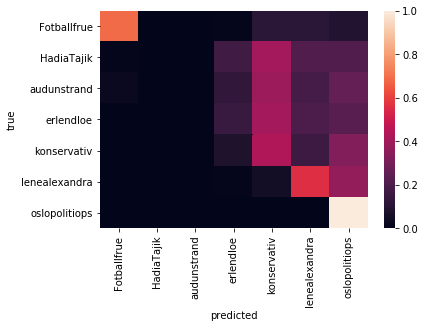

In [19]:
sns.heatmap(rel_confusion)

In [20]:
def show_random_error():
    errors = np.where(y_test != yhat)[0]
    idx = np.random.choice(errors)
    print('--- Tweet: ---')
    print(decode_tweet(X_test[idx,]))
    
    print("Model believes:\t %s" %ind2class[yhat[idx]])
    print("True author:\t %s" %ind2class[y_test[idx]])

In [21]:
show_random_error()

--- Tweet: ---
deilig å komme hjem fra jobb til ferdig middag 
Model believes:	 oslopolitiops
True author:	 lenealexandra


## Now it's your turn..

Are you able to make a better model than the one we just ran? 

Possible extensions of the model:

- Try to increase the width of the dense layer (https://keras.io/layers/core/#dense)
- Try to adjust the learning rate of your optimizer. Lower learning rates takes long but usually gives better results (https://keras.io/optimizers/)
- Try to use a different optimizer. The Adam optizer is often a good alternative 
- Try to stack another dense layer on top of the one you have (or many!)
- We are just using the "average" vector to predict. Could we try to stack the words horizontally instead? (https://keras.io/layers/core/#reshape)
- Are the training accuracy much higher than the test accuracy? Try to add Dropout (https://keras.io/layers/core/#dropout) or Batch Normalization (https://keras.io/layers/normalization/)
- Instead those average vectors, a very fancy alternative approach would be to try to model a tweet as a recurrent neural network (https://keras.io/layers/recurrent/)